In [12]:
#Практична робота 9.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [13]:
num_classes = 10
num_features = 784
learning_rate = 0.001
training_steps = 3000
batch_size = 256
display_step = 100
n_hidden_1 = 128
n_hidden_2 = 256

In [14]:
from tensorflow.keras.datasets import fashion_mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Перетворюємо цілочисельні пікселі до типу float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо зображення у вектори
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішуємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

4422102/4422102 [==============================] - 0s 0us/step


In [15]:
# Створюємо нейронну мережу
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)


class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
        self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
        self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

    def __call__(self, x):
        x1 = self.layer_1(x, activation=0)
        x2 = self.layer_2(x1, activation=0)
        x3 = self.layer_3(x2, activation=1)
        return x3

In [16]:
# Функція помилки (крос-ентропія)
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Функція точності
def accuracy(y_pred, y_true):
    acc = tf.metrics.Accuracy()
    acc.update_state(y_true, tf.argmax(y_pred, axis=1))
    return acc.result()


In [17]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(nn, input_x, output_y):
  # Для припасування ваг мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
        
    # Створимо список параметрів, що оптимізуються.
    trainable_variables = nn.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)
    
    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [18]:
# Створюємо нейронну мережу
neural_net = NN(name="fashion_mnist")

# Функція навчання
def train(nn, input_x, output_y):
    optimizer = tf.optimizers.SGD(learning_rate)
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)
        trainable_variables = nn.trainable_variables
        gradients = g.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

loss_history = []
accuracy_history = []

# Тренуємо мережу
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
    train(neural_net, batch_x, batch_y)
    if step % display_step == 0:
        pred = neural_net(batch_x)
        current_loss = cross_entropy(pred, batch_y)
        loss_history.append(current_loss)
        current_accuracy = accuracy(pred, batch_y)
        accuracy_history.append(current_accuracy)
        print(f"Step: {step}, Loss: {current_loss}, Accuracy: {current_accuracy}")

Step: 0, Loss: 3044.2587890625, Accuracy: 0.12890625
Step: 100, Loss: 261.4873046875, Accuracy: 0.69921875
Step: 200, Loss: 202.1679229736328, Accuracy: 0.73828125
Step: 300, Loss: 165.46665954589844, Accuracy: 0.7734375
Step: 400, Loss: 186.7847900390625, Accuracy: 0.73046875
Step: 500, Loss: 181.5059356689453, Accuracy: 0.765625
Step: 600, Loss: 173.59954833984375, Accuracy: 0.76171875
Step: 700, Loss: 206.946044921875, Accuracy: 0.70703125
Step: 800, Loss: 163.74990844726562, Accuracy: 0.78125
Step: 900, Loss: 158.0574188232422, Accuracy: 0.76953125
Step: 1000, Loss: 141.7465362548828, Accuracy: 0.81640625
Step: 1100, Loss: 125.23407745361328, Accuracy: 0.78125
Step: 1200, Loss: 136.86447143554688, Accuracy: 0.79296875
Step: 1300, Loss: 151.88475036621094, Accuracy: 0.81640625
Step: 1400, Loss: 121.12130737304688, Accuracy: 0.80859375
Step: 1500, Loss: 144.92466735839844, Accuracy: 0.8046875
Step: 1600, Loss: 123.13949584960938, Accuracy: 0.828125
Step: 1700, Loss: 158.2410583496093

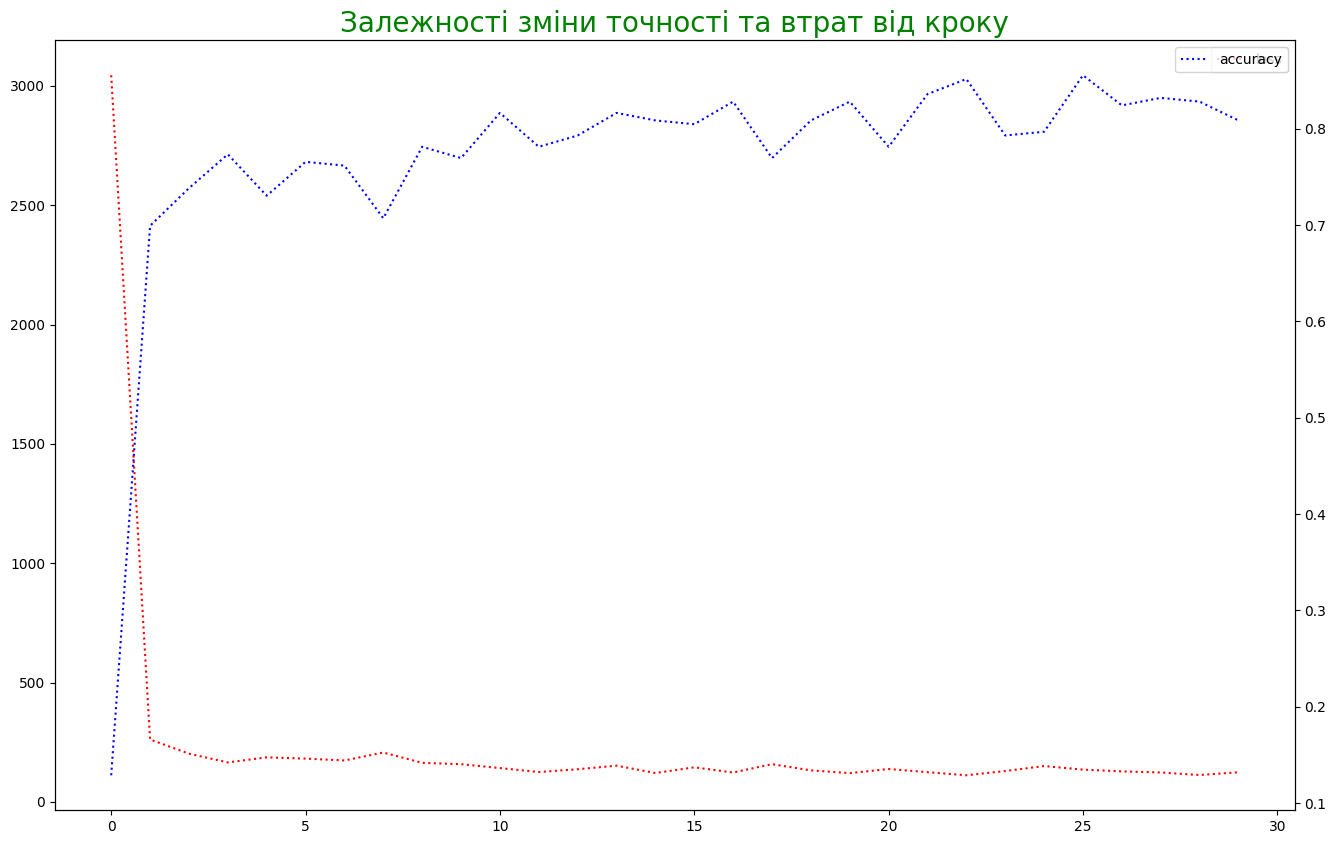

In [25]:
# Виведення графіків точності та втрат
fig, axs = plt.subplots(figsize=(16, 10))
axs.plot(loss_history, 'r', label='loss', linestyle=":")
axs.legend()

axs2=axs.twinx()
axs2.plot(accuracy_history, 'b', label='accuracy', linestyle=":")
plt.legend()

plt.title('Залежності зміни точності та втрат від кроку', fontsize=20, color='g')
plt.show()

In [20]:
# Обчислення точності навченої нейромережі
neural_net_accuracy = accuracy(neural_net(x_train), y_train)
print(f"Accuracy: {neural_net_accuracy}")

Accuracy: 0.8147833347320557


True: 2 Predict: 6 False
True: 4 Predict: 4 True
True: 4 Predict: 4 True
True: 7 Predict: 7 True
True: 9 Predict: 9 True
True: 2 Predict: 2 True
True: 2 Predict: 2 True
True: 2 Predict: 2 True
True: 1 Predict: 1 True
True: 8 Predict: 8 True


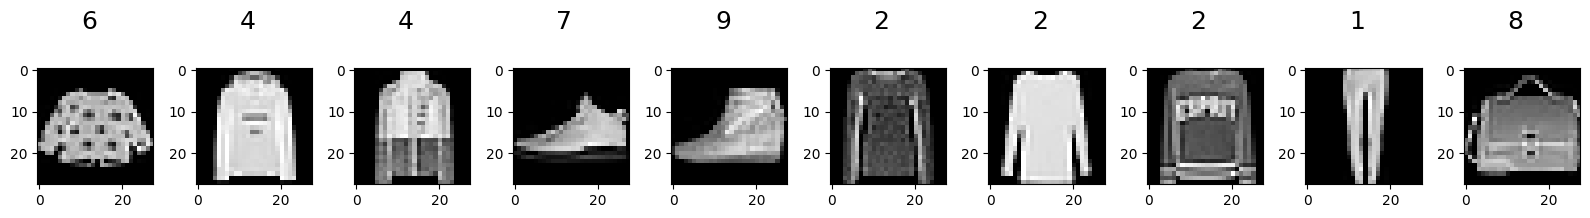

In [21]:
# Тестування навченої нейромережі на 10 зображеннях
test_img = np.random.permutation(x_test.shape[0])[:10]
y_test_true = y_test[test_img]
pred_data = [np.argmax(x) for x in neural_net(x_test[test_img])]

plt.figure(figsize=(16, 6))
for i in range(10):
    print(f"True: {y_test_true[i]} Predict: {pred_data[i]} {True if y_test_true[i] - pred_data[i] == 0 else False}")
    plt.subplot(1, 10, (i + 1))
    plt.imshow(x_test[test_img[i]].reshape(28, 28), cmap='gray')
    plt.text(x=10, y=-10, s=pred_data[i], fontsize=18)
    
plt.tight_layout()
plt.show()